In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **오디오 감정 분류 모델 생성**

# 라이브러리 호출

In [ ]:
!pip install samplerate

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import librosa.display
from sklearn.preprocessing import scale
import math
import soundfile
import samplerate
import pickle
import joblib
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# 모델 불러오기
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Embedding, MaxPooling1D,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


# 모델 검증 및 평가
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

- 데이터 호출

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/kt/bigproject/nemotion/final_result.csv")

# 데이터 전처리

## 오디오 어그멘테이션
1. 오디오 노이즈 추가
2. 오디오 피치 조절

In [ ]:
def noise(data, STD_N):
  """원본 데이터에 노이즈 추가"""
  xf, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/"+ data, sr = 16000)
  RMS = math.sqrt(np.mean(xf**2))
  noise = np.random.normal(0, STD_N, xf.shape[0])
  signal_noise = xf+noise
  soundfile.write('noise/n_'+data,signal_noise,16000)

In [ ]:
def pitch(data):
  """원본 데이터에 피치 조절"""
  xx, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/"+data, sr=16000)
  out_data1 = samplerate.resample(xx, 0.8, 'sinc_best')
  out_data2 = samplerate.resample(xx, 1.3, 'sinc_best')
  soundfile.write('pitch/h_'+data,out_data1,16000)
  soundfile.write('pitch/d_'+data,out_data2,16000)

In [ ]:
# cd /content/drive/MyDrive/kt/bigproject/nemotion

/content/drive/MyDrive/kt/bigproject/nemotion


In [ ]:
for i in range(len(data)):
  noise(data["audio_name"][i].strip(),0.005)

In [ ]:
for i in range(len(data)):
  pitch(data["audio_name"][i].strip())

- 실행 예시

In [ ]:
# 노이즈 조절
xf, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/"+ data["audio_name"][0], sr = 16000)
plt.plot(xf)
plt.show()
RMS = math.sqrt(np.mean(xf**2))
STD_N = 0.01
noise = np.random.normal(0, STD_N, xf.shape[0])
signal_noise = xf+noise
plt.plot(signal_noise)
plt.show

In [ ]:
# 피치 조절
import samplerate
import IPython.display as ipd
xx, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/"+data["audio_name"][0], sr=16000)
out_data1 = samplerate.resample(xx, 0.8, 'sinc_best')
out_data2 = samplerate.resample(xx, 1.3, 'sinc_best')

print('Higher pitch:')
ipd.display(ipd.Audio(out_data1, rate=sr))
print('Lower pitch:')
ipd.display(ipd.Audio(out_data2, rate=sr))

Higher pitch:


Lower pitch:


In [ ]:
# 파일 저장
import soundfile
soundfile.write('noise/n_'+data["audio_name"][0],signal_noise,16000)

- 오디오 데이터 어그멘테이션 추가 라벨링

In [ ]:
noise_list = os.listdir('./noise')
pitch_list = os.listdir('./pitch')

In [ ]:
tmp = []
for i in range(len(noise_list)):
  tmp.append([noise_list[i],list(data[data["audio_name"].str.contains(noise_list[i][2:])]["emotion"])[0]])
data = data.append(pd.DataFrame(tmp, columns=['audio_name','emotion']))

In [ ]:
tmp2 = []
for i in range(len(pitch_list)):
  tmp2.append([pitch_list[i],list(data[data["audio_name"].str.contains(pitch_list[i][2:])]["emotion"])[0]])
data = data.append(pd.DataFrame(tmp2, columns=['audio_name','emotion']))

In [ ]:
data.reset_index(inplace=True)
del data["index"]

In [ ]:
data.to_csv("final_result.csv", index=False, encoding='utf-8-sig')

## 오디오 피쳐 추출

- mfcc로 데이터 특징 추출
  - 파라미터
    - n_mfcc : 26
    - sr : 16000
    - n_fft : 400
    - hop_length = 160

In [ ]:
data["audio_name"][0]

'1651753197166.wav'

In [ ]:
x = []
for i in tqdm(range(len(data))):
  if data["audio_name"][i][0] == 'n':
    xf, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/noise/"+ data["audio_name"][i], sr = 16000)
  elif data["audio_name"][i][0] == 'd' or data["audio_name"][i][0] == 'h':
    xf, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/pitch/"+ data["audio_name"][i], sr = 16000)
  else:
    xf, sr = librosa.load("/content/drive/MyDrive/kt/bigproject/nemotion/origin/"+ data["audio_name"][i].strip(), sr = 16000)
  mfcc_1 = librosa.feature.mfcc(y=xf, sr=16000, n_mfcc=100, n_fft=400, hop_length = 160)
  # mfcc_1 = scale(mfcc_1, axis=1)
  feature = data["audio_name"][i]
  feature = np.append(feature, np.mean(mfcc_1.T, axis=0))
  x.append(feature)

100%|██████████| 1180/1180 [06:52<00:00,  2.86it/s]


In [ ]:
# librosa.display.specshow(mfcc_1)

- 추출한 특징 저장

In [ ]:
today = datetime.datetime.today()
save_folder_name = str(today).split(".")[0].replace(" ", "_").replace(":", "_")[:-3]
print(save_folder_name)

2022-05-08_09_03


In [ ]:
with open("x_feature"+save_folder_name+".pickle","wb") as fw:
    pickle.dump(x, fw)

## 데이터 정리

- mfcc로 데이터 특징 추출한 파일 호출

In [ ]:
# cd /content/drive/MyDrive/kt/bigproject/nemotion

/content/drive/MyDrive/kt/bigproject/nemotion


In [ ]:
with open('x_feature2022-05-07_17_06.pickle', 'rb') as f:
    x = pickle.load(f)

In [ ]:
x = pd.DataFrame(x)
x.head(2)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,1651753197166.wav,-566.843,70.81106,17.963993,10.04262,-11.183487,7.8656144,-4.8193665,-7.255421,0.02706848,...,-6.4141593,-4.9985223,-5.5781045,-6.1453643,-5.5371327,-4.5503526,-5.1019716,-0.8857117,-0.34597626,2.0237305
1,1651754164847.wav,-599.074,47.51433,15.505734,10.031389,-16.752226,0.9554283,-7.3342023,-4.395735,-1.3105018,...,-3.7526321,-3.7205942,-5.545696,-3.6101182,-3.5574927,-1.9557906,-0.86388475,-1.2085032,-0.41900176,1.5506213


In [ ]:
x["audio_name"]= x[0] 
x.drop(0,axis=1, inplace=True)
dff = pd.merge(x,data,on="audio_name")

In [ ]:
x = dff.drop(["audio_name","emotion"], axis=1)
y = dff.loc[:,"emotion"]

In [ ]:
x = x.astype('float')

## 데이터 분할

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## 스케일링

In [ ]:
x_train_s = x_train.copy()
x_val_s = x_val.copy()
x_test_s = x_test.copy()

In [ ]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train_s)
x_val_s = scaler.transform(x_val_s)
x_test_s = scaler.transform(x_test_s)

# 모델링

## 머신러닝

In [ ]:
val_pred_result = {}
test_pred_result = {}

### 1. SVM

In [ ]:
# train 데이터 학습하기
svm_model = SVC()
params = {'C': [1, 10],
              'gamma': [1, 0.1],
              'kernel': ['rbf']}
 
model_svm = GridSearchCV(svm_model, params, refit = True, scoring='accuracy', verbose = 3)
model_svm.fit(x_train_s, y_train)
print(model_svm.best_params_)
print(model_svm.best_score_)

print("====="*20)
print("================== val 데이터로 평가 ====================")
y_pred = model_svm.predict(x_val_s)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
val_pred_result['SVM'] = [accuracy_score(y_val, y_pred)]

print("====="*20)
print("================== test 데이터로 평가 ====================")
y_pred_test = model_svm.predict(x_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
test_pred_result['SVM'] = [accuracy_score(y_test, y_pred_test)]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.450 total time=   0.1s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.444 total time=   0.0s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.483 total time=   0.0s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.430 total time=   0.0s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.483 total time=   0.0s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.377 total time=   0.0s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.371 total time=   0.1s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.391 total time=   0.0s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.384 total time=   0.0s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.377 total time=   0.0s
[CV 1/5] END .........C=10, gamma=1, kernel=rbf;, score=0.603 total time=   0.1s
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;,

### 2. RandomForest

In [ ]:
# train 데이터 학습하기
rf_model = RandomForestClassifier(random_state = 42)
params = {
    'max_depth': range(3,6),
    'n_estimators': range(50,500,50),
    'min_samples_leaf':range(8,16,4)
}
model_rf = GridSearchCV(rf_model,params, cv=3, scoring='accuracy', verbose = 3)
model_rf.fit(x_train,y_train)
print(model_rf.best_params_)
print(model_rf.best_score_)

print("====="*20)
print("================== val 데이터로 평가 ====================")
y_pred = model_rf.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
val_pred_result['RandomForest'] = [accuracy_score(y_val, y_pred)]

print("====="*20)
print("================== test 데이터로 평가 ====================")
y_pred_test = model_rf.predict(x_test)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
test_pred_result['RandomForest'] = [accuracy_score(y_test, y_pred_test)]

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END max_depth=3, min_samples_leaf=8, n_estimators=50;, score=0.452 total time=   0.1s
[CV 2/3] END max_depth=3, min_samples_leaf=8, n_estimators=50;, score=0.440 total time=   0.1s
[CV 3/3] END max_depth=3, min_samples_leaf=8, n_estimators=50;, score=0.438 total time=   0.1s
[CV 1/3] END max_depth=3, min_samples_leaf=8, n_estimators=100;, score=0.448 total time=   0.2s
[CV 2/3] END max_depth=3, min_samples_leaf=8, n_estimators=100;, score=0.456 total time=   0.2s
[CV 3/3] END max_depth=3, min_samples_leaf=8, n_estimators=100;, score=0.442 total time=   0.2s
[CV 1/3] END max_depth=3, min_samples_leaf=8, n_estimators=150;, score=0.452 total time=   0.3s
[CV 2/3] END max_depth=3, min_samples_leaf=8, n_estimators=150;, score=0.444 total time=   0.3s
[CV 3/3] END max_depth=3, min_samples_leaf=8, n_estimators=150;, score=0.450 total time=   0.3s
[CV 1/3] END max_depth=3, min_samples_leaf=8, n_estimators=200;, score=0.452 

### 3. XGBoost

In [ ]:
xgb_model = XGBClassifier(random_state = 42)

params = {
    'max_depth': range(3,9),
    'n_estimators': range(50,500,50),
    'learning_rate': [0.1,0.5]
}

model_xgb = GridSearchCV(xgb_model,params, cv=3, scoring='accuracy', verbose=3)
model_xgb.fit(x_train.values,y_train)
print(model_xgb.best_params_)
print(model_xgb.best_score_)

print("====="*20)
print("================== val 데이터로 평가 ====================")
y_pred = model_xgb.predict(x_val.values)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
val_pred_result['XGB'] = [accuracy_score(y_val, y_pred)]

print("====="*20)
print("================== test 데이터로 평가 ====================")
y_pred_test = model_xgb.predict(x_test.values)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
test_pred_result['XGB'] = [accuracy_score(y_test, y_pred_test)]

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.468 total time=   0.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.452 total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.462 total time=   0.2s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.504 total time=   0.3s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.421 total time=   0.3s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.494 total time=   0.3s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=0.504 total time=   0.5s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=0.421 total time=   0.5s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=150;, score=0.498 total time=   0.5s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.500 total tim

### 4. LightGBM

In [ ]:
lgbm_model = LGBMClassifier(random_state = 42)

params = {
    'max_depth': range(3,9),
    'n_estimators': range(30,200,50),
    'learning_rate': [0.1,0.5]
}

model_lgbm = GridSearchCV(lgbm_model,params, cv=3, scoring='accuracy', verbose=3)
model_lgbm.fit(x_train.values,y_train)
print(model_lgbm.best_params_)
print(model_lgbm.best_score_)

print("====="*20)
print("================== val 데이터로 평가 ====================")
y_pred = model_lgbm.predict(x_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
val_pred_result['LGBM'] = [accuracy_score(y_val, y_pred)]

print("====="*20)
print("================== test 데이터로 평가 ====================")
y_pred_test = model_lgbm.predict(x_test.values)
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
test_pred_result['LGBM'] = [accuracy_score(y_test, y_pred_test)]

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=0.468 total time=   0.3s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=0.433 total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=30;, score=0.446 total time=   0.2s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.452 total time=   0.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.468 total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=80;, score=0.458 total time=   0.2s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=130;, score=0.437 total time=   0.3s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=130;, score=0.476 total time=   0.3s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=130;, score=0.442 total time=   0.4s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=180;, score=0.437 total time=  

## 딥러닝

### 1. DNN

In [ ]:
X = np.array(x)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size = 0.2, random_state = 42, stratify=yy)

In [ ]:
x_train_s = x_train.copy()
x_test_s = x_test.copy()

In [ ]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train_s)
x_test_s = scaler.transform(x_test_s)

In [ ]:
x_train_s = x_train_s.reshape(-1,26,1)
x_test_s = x_test_s.reshape(-1,26,1)

In [ ]:
keras.backend.clear_session()
model_1 = Sequential(name='Voice_DNN')
model_1.add(Dense(64,activation='relu', input_shape=(26,)))
model_1.add(Dense(32,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(3,activation='softmax'))
model_1.summary()

print("***"*20)
model_1.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics = ['accuracy'])
today = datetime.datetime.today()
save_file_name = str(today).split(".")[0].replace(" ", "_").replace(":", "_")[:-3]
es = EarlyStopping(monitor='val_loss',patience=10,verbose=1)
base_dir = "/content/drive/MyDrive/kt/bigproject/nemotion/model"
mc = ModelCheckpoint(base_dir+save_file_name+ "_DNNModel_v1.0.h5",monitor='val_loss',save_best_only=True,verbose=1)

history = model_1.fit(x_train_s,y_train, 
                      batch_size=256,
                      epochs=1000,
                      validation_split=0.2,
                      callbacks=[es,mc],
                      verbose=1)

Model: "Voice_DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1728      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3,907
Trainable params: 3,907
Non-trainable params: 0
_________________________________________________________________
************************************************************
Epoch 1/1000
1/3 [=========>....................] - ETA: 1s - loss: 1.1282 - accuracy: 0.3750
Epoch 1: val_loss improved from 

In [ ]:
y_pred = np.argmax(model_1.predict(x_test_s), axis=-1)
y_pred2 = np.array(le.classes_)[y_pred]

y_test2 = np.argmax(y_test, axis=-1)
y_test3 = np.array(le.classes_)[y_test2]

In [ ]:
print(classification_report(y_test3, y_pred2))

              precision    recall  f1-score   support

       anger       0.52      0.60      0.56        81
   happiness       0.45      0.51      0.48        89
         sad       0.51      0.32      0.39        66

    accuracy                           0.49       236
   macro avg       0.49      0.48      0.48       236
weighted avg       0.49      0.49      0.48       236



In [ ]:
print("accuracy",accuracy_score(y_test3, y_pred2))

accuracy 0.4872881355932203


In [ ]:
test_pred_result['DNN'] = [accuracy_score(y_test_d3, y_pred_d2)]

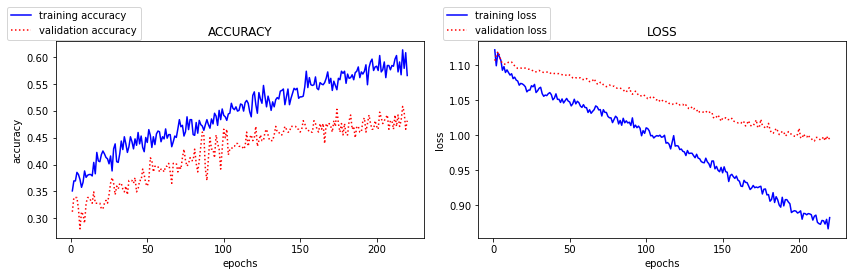

In [ ]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

plot_history(history)

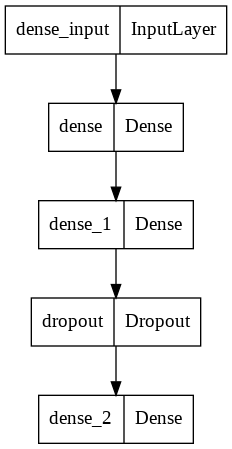

In [ ]:
keras.utils.plot_model(model_1)

### 2. CNN

In [ ]:
keras.backend.clear_session()
model_2 = Sequential(name='Voice_CNN')
model_2.add(Conv1D(64,1, padding='same', input_shape=(26,1)))
model_2.add(Conv1D(128,5, padding='same'))
model_2.add(MaxPooling1D(2,2,padding='same'))
model_2.add(Conv1D(128,5, padding='same'))
model_2.add(MaxPooling1D(2,2,padding='same'))
model_2.add(Conv1D(64,5, padding='same'))
model_2.add(MaxPooling1D(2,2,padding='same'))
model_2.add(Conv1D(64,5, padding='same'))
model_2.add(Flatten())
model_2.add(Dropout(0.1))
model_2.add(BatchNormalization())
model_2.add(Dense(256,activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(3,activation='softmax'))
model_2.summary()

print("***"*20)
model_2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics = ['accuracy'])
today = datetime.datetime.today()
save_file_name = str(today).split(".")[0].replace(" ", "_").replace(":", "_")[:-3]
es = EarlyStopping(monitor='val_loss',patience=10,verbose=1)
base_dir = "/content/drive/MyDrive/kt/bigproject/nemotion/model"
mc = ModelCheckpoint(base_dir+save_file_name+ "_CNNModel_v1.0.h5",monitor='val_loss',save_best_only=True,verbose=1)

history = model_2.fit(x_train_s,y_train, 
                      batch_size=256,
                      epochs=1000,
                      validation_split=0.2,
                      callbacks=[es,mc],
                      verbose=1)

Model: "Voice_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 64)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 128)           41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 128)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 64)             41

In [ ]:
y_pred = np.argmax(model_2.predict(x_test_s), axis=-1)
y_pred2 = np.array(le.classes_)[y_pred]

y_test2 = np.argmax(y_test, axis=-1)
y_test3 = np.array(le.classes_)[y_test2]

In [ ]:
print(classification_report(y_test3, y_pred2))

              precision    recall  f1-score   support

       anger       0.63      0.74      0.68        81
   happiness       0.72      0.71      0.72        89
         sad       0.69      0.56      0.62        66

    accuracy                           0.68       236
   macro avg       0.68      0.67      0.67       236
weighted avg       0.68      0.68      0.68       236



In [ ]:
print("accuracy",accuracy_score(y_test3, y_pred2))

accuracy 0.6779661016949152


In [ ]:
test_pred_result['CNN'] = [accuracy_score(y_test3, y_pred2)]

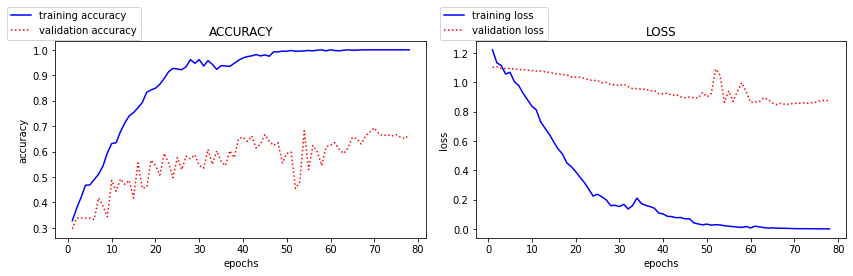

In [ ]:
plot_history(history)

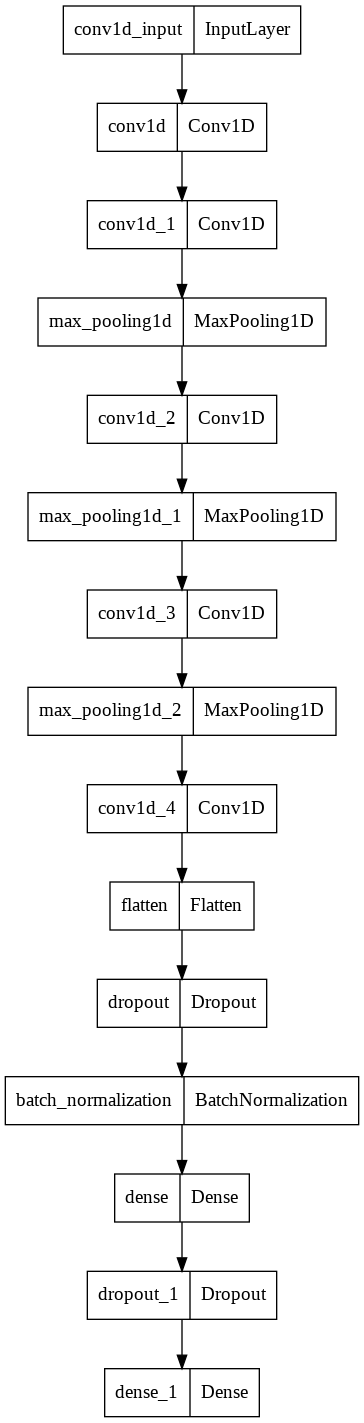

In [ ]:
keras.utils.plot_model(model_2)

## 성능 비교

In [ ]:
test_result_df = pd.DataFrame(test_pred_result).T
test_result_df.columns = ['test_accuracy']
test_result_df

,test_accuracy
SVM,0.279661
RandomForest,0.470339
XGB,0.533898
LGBM,0.508475
CNN,0.677966
DNN,0.487288
